In [1]:
%matplotlib inline

# НАДО СДЕЛАТЬ requirements.txt
# ЗНАЮ, ЗНАЮ

import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path

In [3]:
import utils
import video_utils
from video_utils import VideoScene, VideoInfo
from parse_cvat_annotation import parse_cvat_xml
from calibrate_camera import OctagonMarker

In [4]:
from canvas_helper import (HomographyHelper, warp_img_to_texture,
    get_img_texture_homography, get_point_pairs_2D,
    warp_img_to_texture, make_logo_frame,
    calc_scene_homography_and_texture
)

In [5]:
from canvas_helper import _save_img as save_img

In [6]:
import nn.canvas_inference as inference

In [7]:
from typing import Dict, Tuple, List, Union
from tqdm import tqdm

In [8]:
# '3.4.2' - вынести в requirements
# SIFT из коробки в новых версиях не работает
# и надо билдить вручную
cv2.__version__

'3.4.2'

In [9]:
# путь до видео
# адрес для скачивания - https://cloud.mail.ru/public/51EA/vvGk1W6XF
video_fn = Path('../data/video/ufc234_gastelum_bisping_1080p_nosound_cut.mp4')

In [10]:
# root directory
root_dir = Path('../data/video/ufc234_gastelum_bisping_1080p_nosound_cut')
# путь до папки с кадрами
frame_dir = root_dir / 'frames'

In [11]:
# нарезаем кадры в папку
# video_utils.extract_frames(
#     filename=video_fn,
#     output_dir=frame_dir
# )

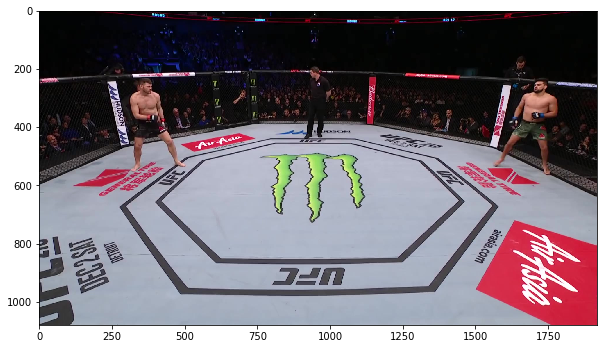

In [12]:
# отображаем первый кадр
frame_path = frame_dir / '0.jpg'
frame = cv2.imread(str(frame_path), cv2.IMREAD_COLOR)
utils.show_img(frame)

In [10]:
# получаем важную информацию по видео
# достаточно прогнать один раз
# а потом сохранить
# video_info = VideoInfo.create_video_info(
#     filename=video_fn,
#     scene_thresh=0.3, # подбирается
#     min_age_scene=20  # подбирается
# )
video_info = VideoInfo.create_video_info(
    filename=video_fn
)

ffprobe cmd: ffprobe -print_format json -select_streams v:0 -show_frames -show_entries frame=pkt_pts,pkt_pts_time,pkt_duration,pkt_duration_time,width,height -i ../data/video/ufc234_gastelum_bisping_1080p_nosound_cut.mp4
ffprobe cmd: ffprobe -print_format json -select_streams v:0 -f lavfi -show_frames -show_entries frame=pkt_pts -i "movie=../data/video/ufc234_gastelum_bisping_1080p_nosound_cut.mp4, select=gt(scene\,0.2)"
ffprobe cmd: ffprobe -print_format json -select_streams v:0 -show_streams -show_entries stream=r_frame_rate,avg_frame_rate,time_base -i ../data/video/ufc234_gastelum_bisping_1080p_nosound_cut.mp4


In [11]:
# смотрим, какие сцены у нас получились
# их первый и последний кадры
# если сцена меняется слишком часто
# то надо подправить
video_info.show_scenes_info()


ufc234_gastelum_bisping_1080p_nosound_cut scenes:
	  0 - (     0,    556)
	  1 - (   557,    629)
	  2 - (   630,   1316)
	  3 - (  1317,   1419)
	  4 - (  1420,   1652)
	  5 - (  1653,   1698)
	  6 - (  1699,   2089)
	  7 - (  2090,   2204)
	  8 - (  2205,   2332)
	  9 - (  2333,   2670)
	 10 - (  2671,   3091)
	 11 - (  3092,   3173)
	 12 - (  3174,   3459)
	 13 - (  3460,   3677)
	 14 - (  3678,   3794)
	 15 - (  3795,   3992)
	 16 - (  3993,   4491)
	 17 - (  4492,   4748)
	 18 - (  4749,   4834)
	 19 - (  4835,   4926)
	 20 - (  4927,   5018)
	 21 - (  5019,   5071)
	 22 - (  5072,   5152)
	 23 - (  5153,   5276)
	 24 - (  5277,   7041)



In [11]:
# сохраняем первый и последний кадр каждой сцены
# для визуальной инспекции (ЕСЛИ НУЖНО)
# scenes_dir = frame_dir.parent / 'scenes_0_3__20'
scenes_dir = frame_dir.parent / 'scenes_test'
# video_utils.save_scenes_first_last_frames(
#     scenes=video_info.get_scenes(),
#     frame_dir=frame_dir,
#     output_dir=scenes_dir,
#     verbose=False
# )

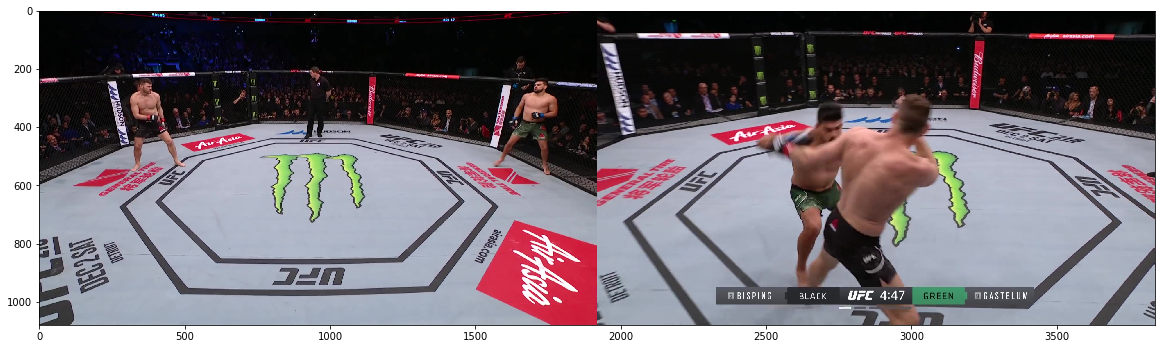

In [15]:
# визуализация первого и последнего кадра сцены
scene_n = 0
video_scene = video_info.get_scenes()[scene_n]
video_scene.show_first_last_frames(frame_dir=frame_dir)

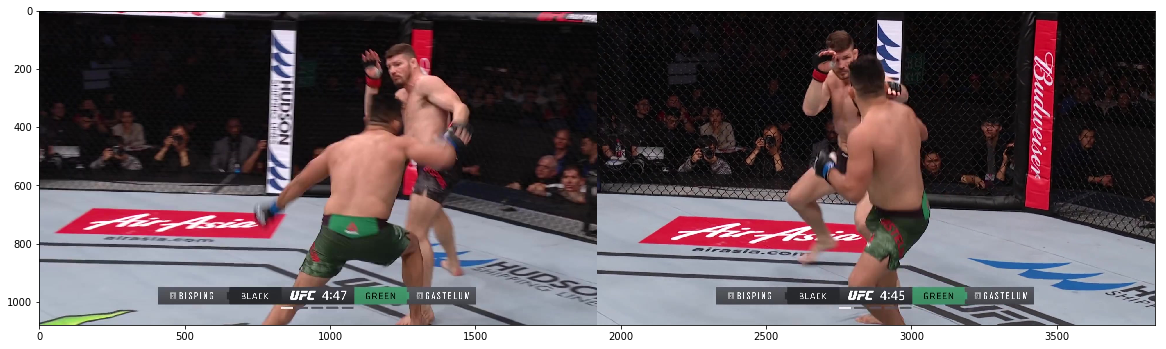

In [16]:
# визуализация первого и последнего кадра сцены
scene_n = 1
video_scene = video_info.get_scenes()[scene_n]
video_scene.show_first_last_frames(frame_dir=frame_dir)

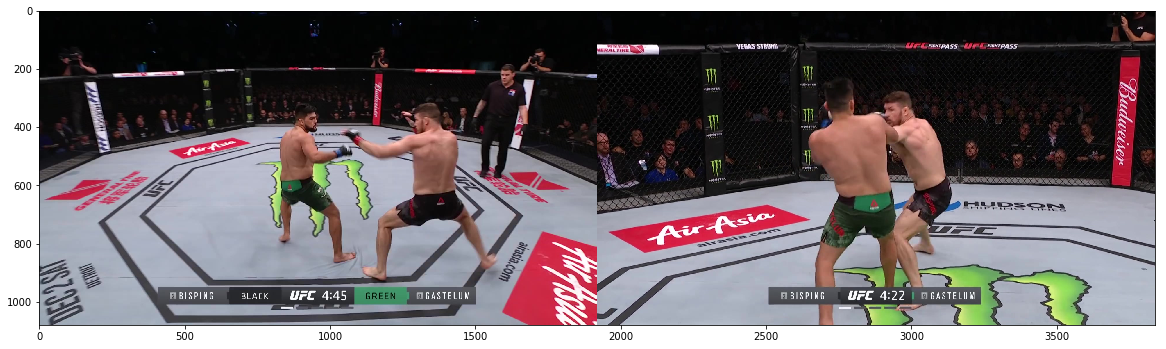

In [17]:
# визуализация первого и последнего кадра сцены
scene_n = 2
video_scene = video_info.get_scenes()[scene_n]
video_scene.show_first_last_frames(frame_dir=frame_dir)

In [16]:
# сохраняем VideoInfo
# video_info.save()

In [18]:
# video_info name
print(video_info.get_name())

ufc234_gastelum_bisping_1080p_nosound_cut


In [13]:
# если нужно подгрузить с диска
video_info = VideoInfo.load(name='ufc234_gastelum_bisping_1080p_nosound_cut')

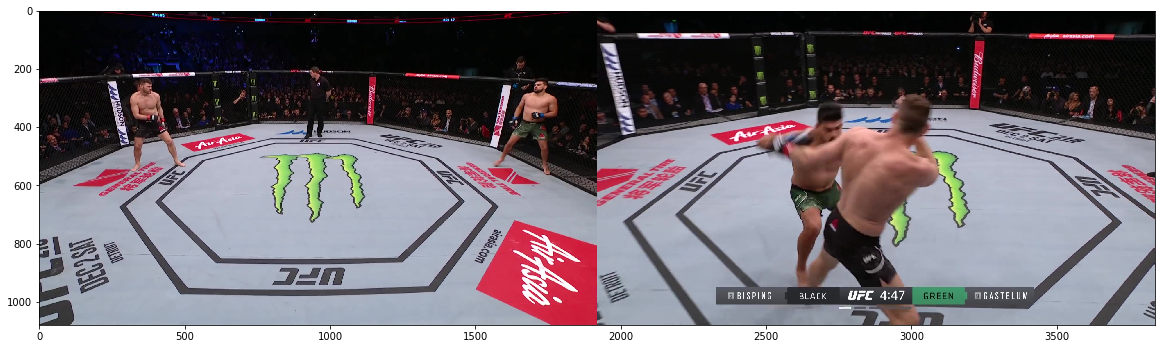

In [14]:
# выбираем первую (0) сцену для демки
# так как для неё есть разметка
scene_n = 0
video_scene = video_info.get_scenes()[scene_n]
video_scene.show_first_last_frames(frame_dir=frame_dir)

In [20]:
# смотрим количество кадров
print(video_scene.get_num_frames())

557


In [21]:
# размер кадра
print(frame.shape)

(1080, 1920, 3)


In [16]:
# НУЖНО ЗАМЕНИТЬ НА ВЕСА @andygoo
# адрес для скачивания - https://cloud.mail.ru/public/2SPx/3iwory7sq
output_dir = root_dir / 'canvas'
weights_path = Path('../data/weights/350ep_diceTern07_bce03.pt')
h, w = frame.shape[:2]

# сегментируем пол
# НУЖНО ЗАМЕНИТЬ НА СЕТКУ @andygoo
# inference.predict(
#     frame_dir=frame_dir,
#     output_dir=output_dir,
#     weights_path=weights_path,
#     batch_size=1,
#     mask_threshold=0.78,
#     height=h,
#     width=w,
#     divider=32, # чтобы размер подгонять
#     save_overlays=True
# )

100%|██████████| 5613/5613 [12:58<00:00,  7.24it/s]


In [15]:
# почему-то детект ключевых точек в SIFT
# лучше, если мы накладываем
# маски на кадр ЗАРАНЕЕ
# но для детекции ключевых точек мы будем
# использовать что-то отличное от SIFT
# поэтому пока оставляем
# frame_dir = root_dir / 'frames'
frame_dir = root_dir / 'canvas/frames'
overlay_dir = root_dir / 'canvas/overlays'
mask_dir = root_dir / 'canvas/masks'

In [16]:
frame_n = video_scene.get_first_frame()

# подгрузим первый кадр сцены и его маску
frame0, mask0 = utils.load_frame_and_mask(
    frame_n=frame_n,
    frame_dir=frame_dir,
    mask_dir=mask_dir
)

# заодно и overlay
overlay_path = overlay_dir / f'{frame_n}.jpg'
overlay0 = cv2.imread(str(overlay_path), cv2.IMREAD_COLOR)

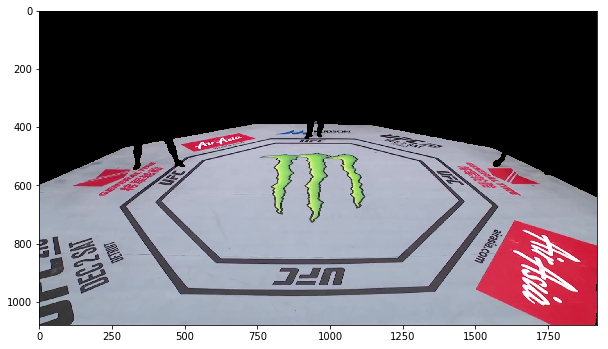

In [24]:
utils.show_img(frame0)

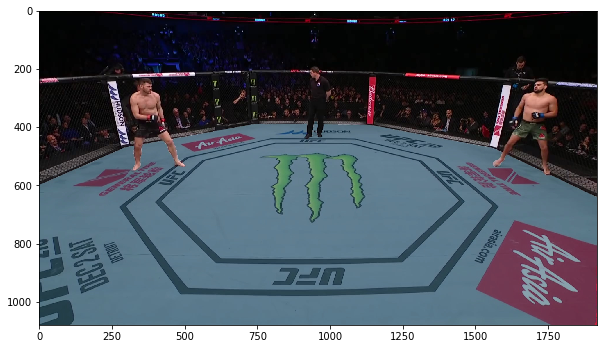

In [25]:
utils.show_img(overlay0)

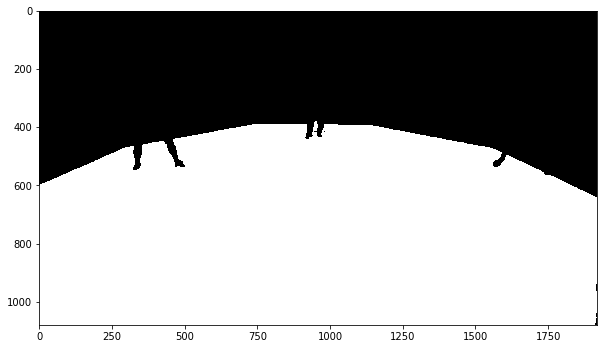

In [26]:
utils.show_img(mask0)

In [17]:
# подгружаем и парсим ручную разметку кадра
# от 4 до 8 точек
# адрес для скачивания - https://cloud.mail.ru/public/8dFs/9XCcPe1wx
anno_fn = '../data/marker/ufc234_gastelum_bisping_1080p_nosound_cut.xml'
anno = parse_cvat_xml(anno_fn)

In [18]:
# объект для удобного взаимодействия
# с меткой на полу
# в 2D и 3D
marker = OctagonMarker()

In [19]:
# точки разметки на кадре с их id
points0, point0_ids = anno.get_frame_points(frame_n)
# тоже самое, но в другом формате
frame0_points = anno.get_frames()[frame_n]
# удаляем точки 0 и 1
# из-за плохой разметки
frame0_points = [point for point in frame0_points if point.get_id() > 1]

# подбираем размер текстуры
# и размер маркера при "виде сверху"
# texture_size: Tuple[int, int] = (1280, 1280)
# marker_size: Tuple[int, int] = (750, 750)

texture_size: Tuple[int, int] = (1920, 1920)
marker_size: Tuple[int, int] = (1126, 1126)

# папочка для сохранения текстуры
# texture_dir = root_dir / 'canvas/texture'
texture_dir = root_dir / 'canvas/texture5'

# получаем начальную homography
# для получения преобразования
# из первого кадра сцены в текстурный вид сверху
init_homo, status, texture_points = get_img_texture_homography(
    frame0_points, marker,
    texture_size=texture_size,
    marker_size=marker_size
)

In [31]:
# начальная homography
print(init_homo)

[[-2.40687015e+00 -5.63769779e+00  3.30736659e+03]
 [ 5.34318080e-02 -1.20278479e+01  4.64168051e+03]
 [ 4.70974811e-05 -5.79780033e-03  1.00000000e+00]]


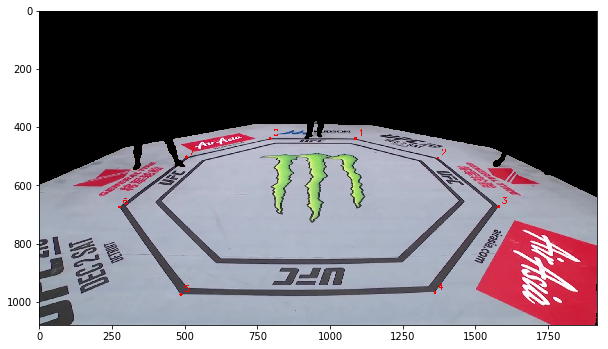

In [32]:
# отрисовываем точки из РУЧНОЙ разметки
vis = utils.draw_points(
    img=frame0,
    mask=None,
    points=points0,
    point_ids=point0_ids,
    draw_ids=True
)
utils.show_img(vis)

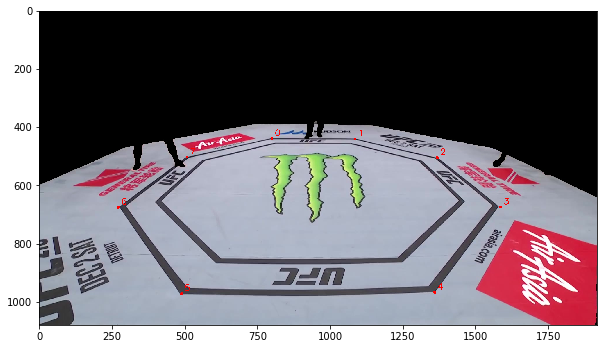

In [33]:
# посмотрим на погрешность
# и отобразим точки из 3D в 2D
# используя полученную матрицу homography
# видно, как точка с point_id=3 съехала чуть-чуть
points_in_img, points_in_texture = get_point_pairs_2D(
    frame_points=anno.get_frames()[frame_n],
    texture_points=texture_points
)
new_points = cv2.perspectiveTransform(
    src=np.array([texture_points.reshape(-1, 2)]),
    m=np.linalg.inv(init_homo)
)[0]

vis = utils.draw_points(
    img=frame0,
    mask=None,
    points=new_points,
    draw_ids=True,
    point_ids=list(range(0, 8))
)
utils.show_img(vis)

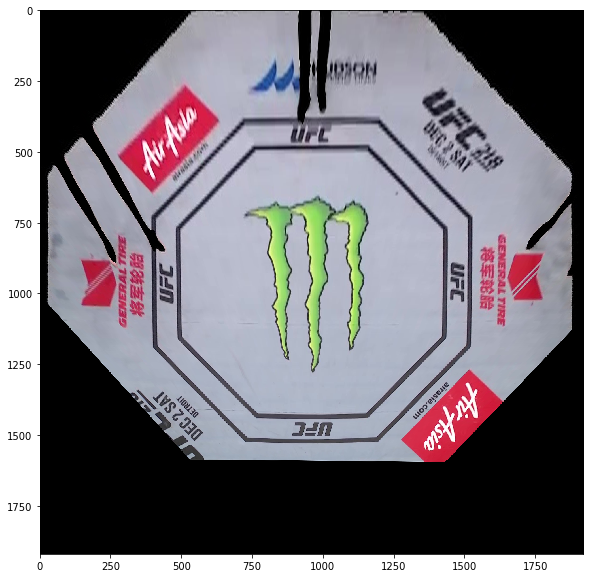

In [34]:
# делаем перспективное преобразование
# первого кадра из сцены в "текстуру"
# и отображаем его
img_warped, mask_warped = warp_img_to_texture(
    img=frame0,
    mask=mask0,
    homography=init_homo,
    texture_size=texture_size
)
utils.show_img(img_warped)

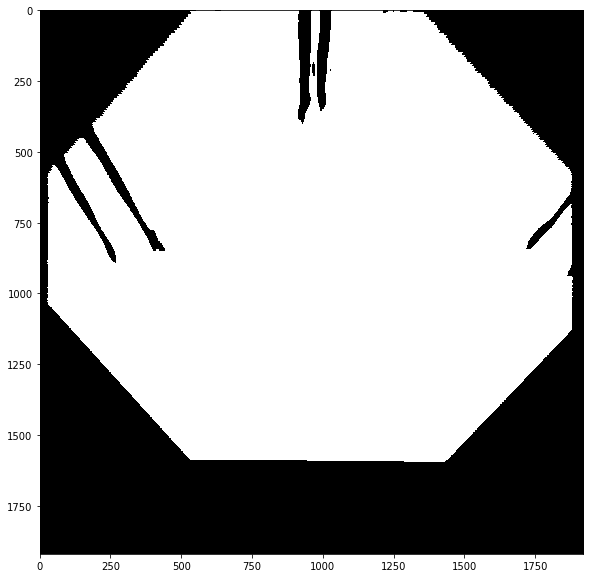

In [35]:
# заодно и маску
utils.show_img(mask_warped)

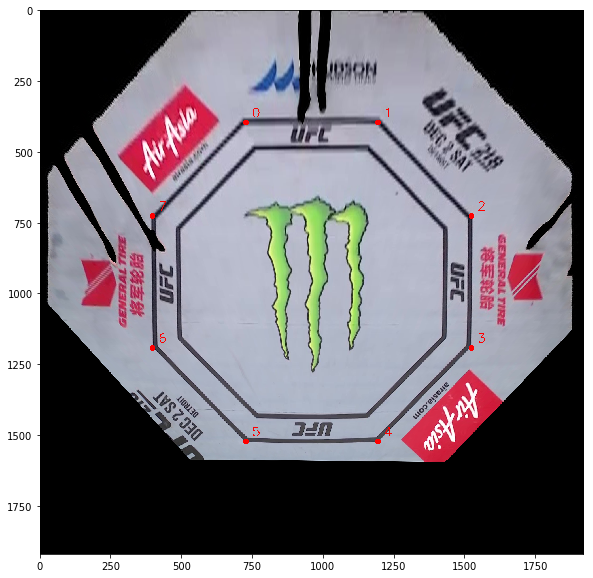

In [36]:
# можно отобразить точки и на "текстуре"
vis = utils.draw_points(
    img=img_warped,
    mask=None,
    points=texture_points,
    draw_ids=True,
    point_ids=list(range(0, 8)),
    radius=10,
    font_scale=1.5,
    font_thickness=2
)
utils.show_img(vis)

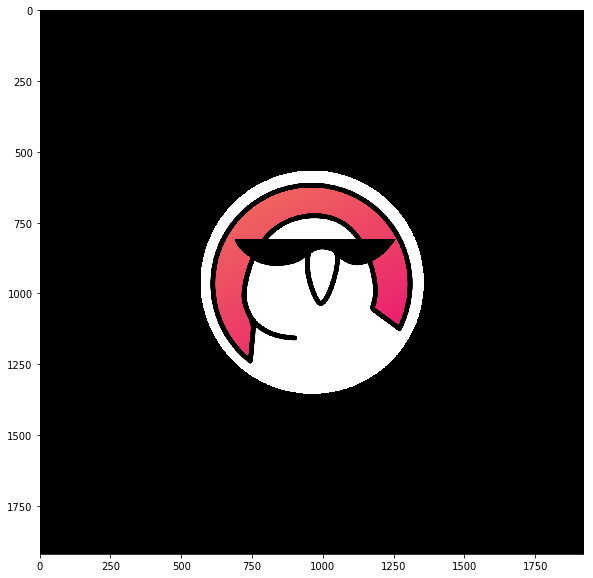

In [37]:
# можно для интереса создать
# новую текстуру для пола
# и отобразить
texture, texture_mask = utils.create_logo_texture(
    logo_fn='../data/logo/ods_logo.png',
    mask_fn='../data/logo/ods_logo_mask.png',
    texture_size=texture_size,
    marker_size=marker_size,
    fraction=0.7
)
utils.show_img(texture)

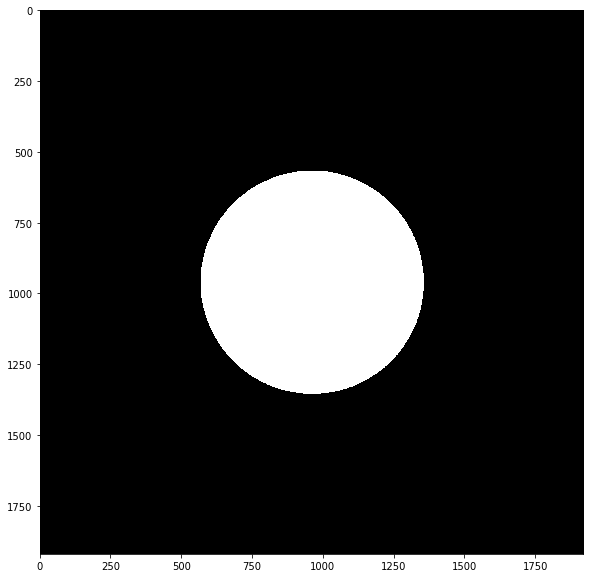

In [38]:
# и маску текстуры
utils.show_img(texture_mask)

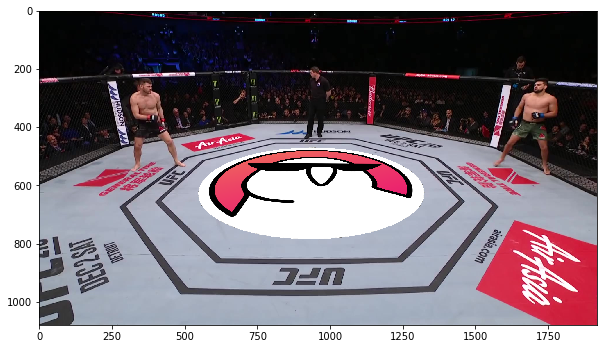

In [40]:
frame_test, mask_test = utils.load_frame_and_mask(
    frame_n=frame_n,
    frame_dir=root_dir / 'frames',
    mask_dir=mask_dir
)

# наложим текстуру поверх
# и отобразим
new_frame = make_logo_frame(
    frame=frame_test,
    mask=mask_test,
    texture=texture,
    texture_mask=texture_mask,
    homo=np.linalg.inv(init_homo),
    draw_points=False
)
utils.show_img(new_frame)

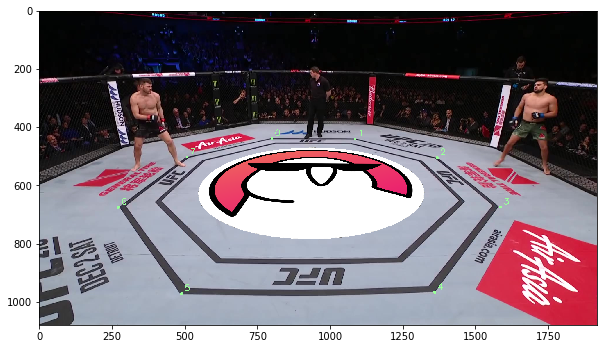

In [41]:
# можно и точки отрисовать заодно
new_frame = make_logo_frame(
    frame=frame_test,
    mask=mask_test,
    texture=texture,
    texture_mask=texture_mask,
    homo=np.linalg.inv(init_homo),
    draw_points=True,
    texture_points=texture_points,
    point_color=(153, 255, 153)
)
utils.show_img(new_frame)

In [20]:
# result_dir тут не используется, метод не был дописан
# по изначальной задумке - тут json должен был сохраняться
# для всех homography в сцене/видео

# ОЧЕНЬ МЕДЛЕННО РАБОТАЕТ!!!!
# Из-за weighted average texture в том числе
# МОЖНО ОПТИМИЗИРОВАТЬ через GPU

# в этом методе я пытался посчитать homography
# для каждого кадра
# а заодно и получить усредненную текстурку
# текстурка получилась не очень
# а вот homography более менее
homo_result = calc_scene_homography_and_texture(
    init_homo=init_homo,
    video_scene=video_scene,
    texture_points=texture_points,
    frame_dir=frame_dir, # используем опять же УЖЕ вырезанные кадры
    mask_dir=mask_dir,
    texture_dir=texture_dir, # папка, куда сохраняем weighted average texture
    texture_size=texture_size,
    texture_alpha=0.1, # weighted average для текстуры
    result_name=(
        'ufc234_gastelum_bisping_1080p_nosound_cut'
        '__homography'
    ),                               # не используется
    result_dir='../data/video/info', # не используется, но папка создаётся
    # отрисовываем точки на каждом кадре
    draw_points=True,
    point_color=(153, 255, 153),
    point_radius=10,
    point_font_scale=1.5,
    point_font_thickness=3
)

100%|██████████| 556/556 [24:12<00:00,  2.62s/it]


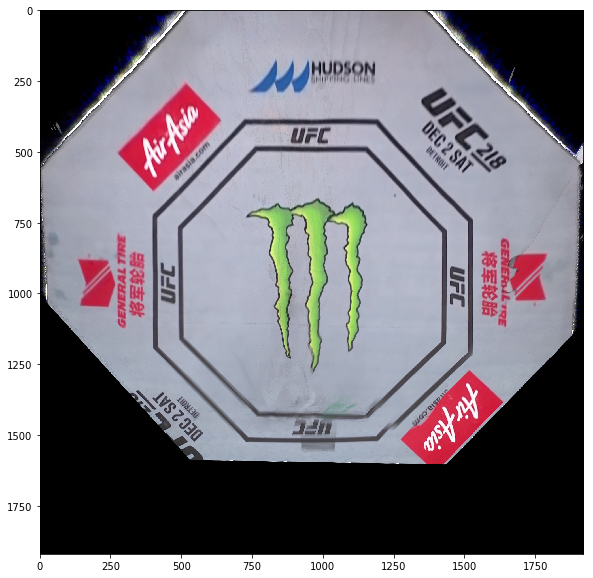

In [54]:
# а вот результирующая текстурка
# после 557 кадров
utils.show_img(homo_result[1])

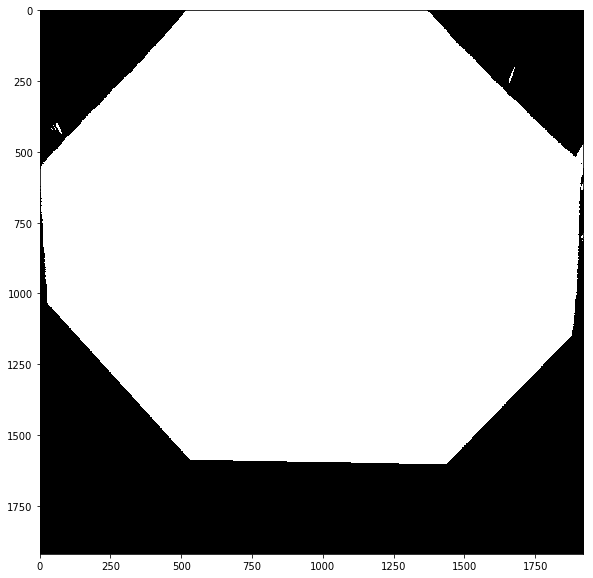

In [55]:
# и маска после 557 кадров
utils.show_img(homo_result[2])

In [56]:
# СДЕЛАЕМ ТЕПЕРЬ ВИДЕО
# С ТЕКСТУРКОЙ ODS

In [57]:
# папка с наложенной
# новой текстурой ods
result_dir = root_dir / 'ods_test'

In [64]:
# вставляем текстурку в каждый кадр
# и сохраняем результат
homos = homo_result[0]
for frame_n_ in tqdm(range(video_scene.get_first_frame(), video_scene.get_last_frame() + 1)):
    frame, mask = utils.load_frame_and_mask(
        frame_n_,
        frame_dir=root_dir / 'frames',
        mask_dir=mask_dir
    )
    new_frame = make_logo_frame(
        frame=frame,
        mask=mask,
        texture=texture,
        texture_mask=texture_mask,
        homo=np.linalg.inv(homos[frame_n_]['texture']),
        texture_points=texture_points,
        point_color=(153, 255, 153)
    )
    save_img(
        img=new_frame,
        frame_n=frame_n_,
        output_dir=result_dir
    )

100%|██████████| 557/557 [00:39<00:00, 14.00it/s]


In [65]:
# смотрим frame rate
# в изначальном видео
print(video_info.avg_frame_rate)

30000/1001


In [66]:
# делаем видео из результата!
video_utils.make_video_from_frames(
    frame_dir=result_dir,
    target_path=result_dir,
    input_fps='30000/1001',  # video_info.avg_frame_rate
    output_fps='30000/1001', # video_info.avg_frame_rate
    crf_quality=17,          # отличное качество
    img_ext='.jpg',
    verbose=True
)

ffmpeg cmd: ffmpeg -framerate 30000/1001 -start_number 0 -i ../data/video/ufc234_gastelum_bisping_1080p_nosound_cut/ods_test/%d.jpg -c:v libx264 -vf "fps=30000/1001, format=yuv420p" -crf 17 -y ../data/video/ufc234_gastelum_bisping_1080p_nosound_cut/ods_test.mp4


In [21]:
# загрузим для интереса другую текстурку для пола
texture_path = '../data/texture/fng91.png'
texture = cv2.imread(texture_path, cv2.IMREAD_COLOR)
texture = cv2.resize(
    src=texture,
    dsize=texture_size,
    interpolation=cv2.INTER_AREA
)
texture_mask = np.ones(shape=texture_size, dtype=texture.dtype) * 255

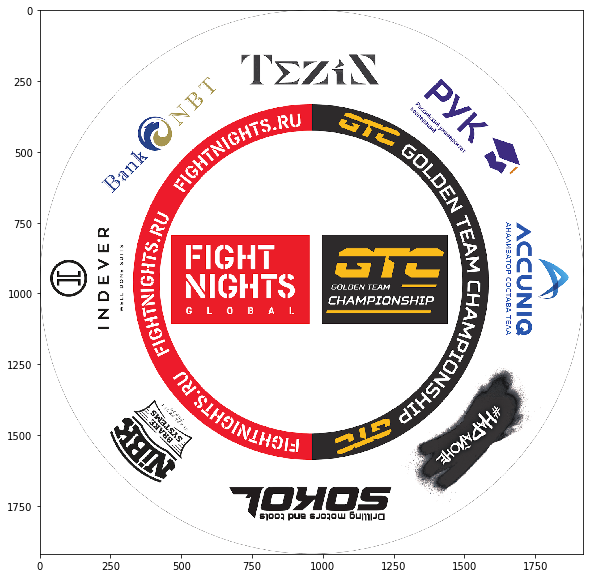

In [22]:
# отобразим
utils.show_img(texture)

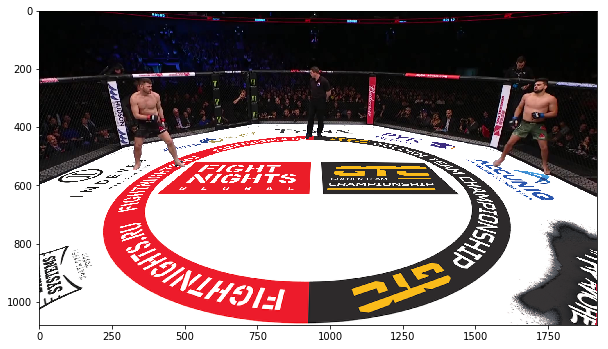

In [23]:
frame_test, mask_test = utils.load_frame_and_mask(
    frame_n=frame_n,
    frame_dir=root_dir / 'frames',
    mask_dir=mask_dir
)

# наложим текстуру поверх
# и отобразим
new_frame = make_logo_frame(
    frame=frame_test,
    mask=mask_test,
    texture=texture,
    texture_mask=texture_mask,
    homo=np.linalg.inv(init_homo),
    draw_points=False
)
utils.show_img(new_frame)

In [24]:
# СДЕЛАЕМ ТЕПЕРЬ ВИДЕО
# С ТЕКСТУРКОЙ FIGHT NIGHTS

In [25]:
# папка с наложенной
# новой текстурой ods
result_dir = root_dir / 'fng91_test'

In [26]:
# вставляем текстурку в каждый кадр
# и сохраняем результат
homos = homo_result[0]
for frame_n in tqdm(range(video_scene.get_first_frame(), video_scene.get_last_frame() + 1)):
    frame, mask = utils.load_frame_and_mask(
        frame_n,
        frame_dir=root_dir / 'frames',
        mask_dir=mask_dir
    )
    new_frame = make_logo_frame(
        frame=frame,
        mask=mask,
        texture=texture,
        texture_mask=texture_mask,
        homo=np.linalg.inv(homos[frame_n]['texture']),
        draw_points=False
    )
    save_img(
        img=new_frame,
        frame_n=frame_n,
        output_dir=result_dir
    )

100%|██████████| 557/557 [00:38<00:00, 14.47it/s]


In [27]:
# делаем видео из результата!
video_utils.make_video_from_frames(
    frame_dir=result_dir,
    target_path=result_dir,
    input_fps='30000/1001',  # video_info.avg_frame_rate
    output_fps='30000/1001', # video_info.avg_frame_rate
    crf_quality=17,          # отличное качество
    img_ext='.jpg',
    verbose=True
)

ffmpeg cmd: ffmpeg -framerate 30000/1001 -start_number 0 -i ../data/video/ufc234_gastelum_bisping_1080p_nosound_cut/fng91_test/%d.jpg -c:v libx264 -vf "fps=30000/1001, format=yuv420p" -crf 17 -y ../data/video/ufc234_gastelum_bisping_1080p_nosound_cut/fng91_test.mp4


In [67]:
# А ДАЛЬШЕ НУЖНО
# на основе homos (homography со всех кадров)
# получить точки для каждого кадра
# и загнать их в
# calibrate_camera.calibrate_camera(...)
# но лучше заранее откалибровать каждую камеру, конечно же :)

# эту часть решил пока не расписывать